In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit

# Maths

The PDE describing peat surface elevation over time is

$$
\frac{\partial^2 p}{\partial t^2} + \alpha \frac{\partial p}{\partial t} = \frac{αT}{S_y}\nabla^2 p + \frac{α}{S_y}(P-ET),
$$
where $α$ is the peat accumulation or subsidence rate, and it comes from

$$
p_t = a_p - α ζ
$$
where $ζ$ is water table below homogeneous peat surface, and $a_p$ is constant peat accumulation rate when WTD is at the surface, i.e., $ζ=0$.

This PDE is analogous to a wave equation. In 1D:
$$
\frac{\partial^2 u}{\partial t^2} + b\frac{\partial u}{\partial t} = c^2\frac{\partial^2 u}{\partial x^2} + f_{ext}(x,t),
$$
where $b$ is the friction term and $f_{ext}$ is an external force that drives the system.



# 1D Numerics

  Very simple numerical scheme for the drained of the wave equation, given by eq. (23) of
  http://hplgit.github.io/INF5620/doc/notes/wave-sphinx/main_wave.html

In [3]:
# Mesh
L = 10000 # string length
grid_length = int(100) # array length
x = np.linspace(0, L, num=grid_length)
MAX_NITER = int(1e5)
simulated_time = int(200000)
t = np.linspace(0, simulated_time, num=MAX_NITER)

dx = x[1] - x[0]
dt = t[1] - t[0]

# Parameters
alpha = 0.0431 # friction term
diffusivity = 100 # transmisivity/storage
source = 0.8 # (P-ET) in m/yr
storage = 5000 # (P-ET)/storage
c_squared = alpha*diffusivity # coefficient of wave
f_ext = alpha * source/storage * np.ones(shape=grid_length) # external force

courant = np.sqrt(c_squared)*dt/dx # Courant number
if courant >= 1:
    raise Warning(f' C = {courant} > 1. Stability criterion not met')

In [4]:
# Numerical scheme

# A finite differences matrix
fin_diff_matrix = (np.diag(np.ones(shape=grid_length-1), k=-1) +
             np.diag(np.ones(shape=grid_length-1), k=+1) -
             np.diag(2*np.ones(shape=grid_length))) 

@njit
def run_one_timestep(u, u_old):
    return (1/(1 + 0.5*alpha*dt)*((0.5*alpha*dt - 1) * u_old +
                                2*u +
                                courant**2*(fin_diff_matrix @ u) +
                                 dt**2 * f_ext
                            )
           )
 
@njit 
def run_all_timesteps(u, u_old, max_niter, grid_length, diri_bc_left, diri_bc_right, drainage_niter, drainage_position):
    solution = np.zeros(shape=(max_niter, grid_length))
    solution[0] = u
    for niter in range(1, max_niter):
        # Diri BC
        u[0] = diri_bc_left
        u[grid_length-1] = diri_bc_right
        
        # Set a drainage canal. It's easy: fix p at some level.
        if niter > drainage_niter:
            u[drainage_position] = 1.
        
        u_new = run_one_timestep(u, u_old) #solve
        solution[niter] = u_new
        
        u_old = u.copy()
        u = u_new.copy()
        
    return solution  


In [5]:
# %% Solve
# Initial condition
u = np.zeros(shape=grid_length)
# Triangular
# u[:int(grid_length/2)] = np.linspace(start=0, stop=1., num=int(grid_length/2))
# u[int(grid_length/2):] = np.linspace(start=1., stop=0., num=int(grid_length/2))
                                      
# Diri BC
DIRI_BC_LEFT = 0
DIRI_BC_RIGHT = 0
# Diri BC at initial conditions
u[0] = DIRI_BC_LEFT
u[grid_length-1] = DIRI_BC_RIGHT
u_old = u.copy()

# Drainage
DRAINAGE_NITER = MAX_NITER/2 # when to dig a ditch
DRAINAGE_POSITION = int(grid_length/4)

# Solve
drained = run_all_timesteps(u, u_old, 
                             max_niter=MAX_NITER, grid_length=grid_length,
                             diri_bc_left=DIRI_BC_LEFT, diri_bc_right=DIRI_BC_RIGHT,
                             drainage_niter=DRAINAGE_NITER, drainage_position= DRAINAGE_POSITION)

if np.any(np.isnan(drained[-1])):
    raise ValueError('Error in simulation. NaN in solution')

# 1D Plots and animation

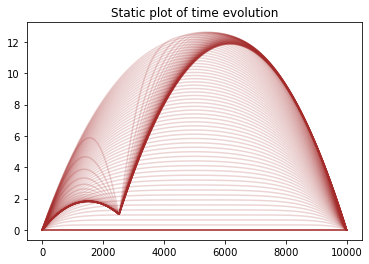

In [6]:
%matplotlib inline
# %% Plot
plt.figure()
plt.title('Static plot of time evolution')

for niter in range(0, MAX_NITER):
    if niter==0:
        plt.plot(x, drained[0], color='brown', alpha=1.0)
    if niter%int(MAX_NITER/100) == 0:  
        plt.plot(x, drained[niter], color='brown', alpha=0.2)


In [7]:
# %% Animate
PLOT_ANIMATIONS = False
if PLOT_ANIMATIONS:
    from matplotlib.animation import FuncAnimation

    INTERVAL = 100 # Interval to sample plotting times from solution. If = 1, all times are plotted
    animation_solution = drained[::INTERVAL]
    animation_niter = animation_solution.shape[0]

    # initializing a figure in 
    # which the graph will be plotted
    fig = plt.figure() 
    
    # marking the x-axis and y-axis
    axis = plt.axes(xlim =(0, L), 
                    ylim =(0, np.max(solution))) 
    
    # initializing a line variable
    line, = axis.plot([], [], lw = 2, alpha=0.7, color='brown') 

    def init(): 
        line.set_data([], [])
        return line,

    def animate(i):

        line.set_data(x, animation_solution[i])
        
        return line,

    
    anim = FuncAnimation(fig, animate, init_func = init,
                        frames = animation_niter, interval = 100, blit = True)

    from IPython.display import HTML
    HTML(anim.to_html5_video())
        
    anim.save(r'C:\Users\03125327\github\subsi_wave\peatland.mp4', 
            writer = 'ffmpeg', fps = 30)

## Subsidence = dp/dt



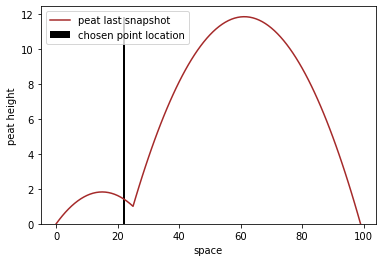

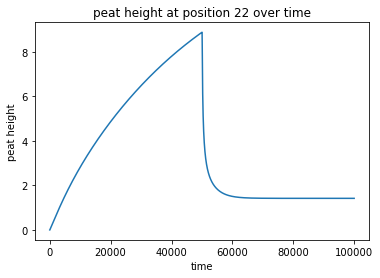

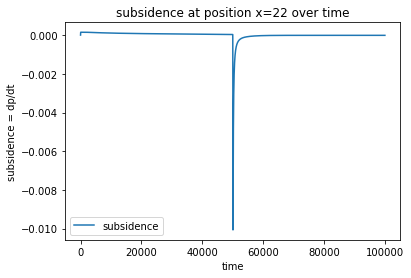

In [8]:

LOCATION_IN_X = int(grid_length/4.5)

# Plot chosen location in peatland
plt.figure()
plt.ylabel('peat height')
plt.xlabel('space')
plt.plot(drained[-1], color='brown', label='peat last snapshot')
plt.bar(x=LOCATION_IN_X, height=drained[-1].max(), color='black', label='chosen point location')
plt.legend()

# Surface height over time of a given point in x
plt.figure()
plt.plot(drained[:,LOCATION_IN_X])
plt.title(f'peat height at position {LOCATION_IN_X} over time')
plt.ylabel('peat height')
plt.xlabel('time')
plt.show()

# Subsidence
subsidence = np.diff(drained, axis=0)/dt
plt.figure()
plt.plot(subsidence[:,LOCATION_IN_X], label='subsidence')
plt.title(f'subsidence at position x={LOCATION_IN_X} over time')
plt.ylabel('subsidence = dp/dt')
plt.xlabel('time')
plt.legend()


# peat (and C) loss

To compute the amount of peat (and therefore also C) lost at each point in time, we neeed to compute the difference between the natural and the drained situations.

Cumulative peat loss is the area, i.e., the integral between the two curves

In [9]:
# Compute undrained evolution

# Initial condition
u = np.zeros(shape=grid_length)
                          
# Diri BC
DIRI_BC_LEFT = 0
DIRI_BC_RIGHT = 0
# Diri BC at initial conditions
u[0] = DIRI_BC_LEFT
u[-1] = DIRI_BC_RIGHT
u_old = u.copy()

# Drainage
DRAINAGE_NITER = np.inf # when to dig a ditch
DRAINAGE_POSITION = 0

# Solve undrained case
undrained = run_all_timesteps(u, u_old, 
                             max_niter=MAX_NITER, grid_length=grid_length,
                             diri_bc_left=DIRI_BC_LEFT, diri_bc_right=DIRI_BC_RIGHT,
                             drainage_niter=DRAINAGE_NITER, drainage_position= DRAINAGE_POSITION)



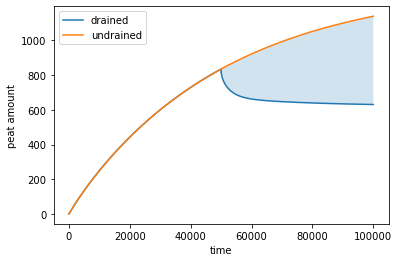

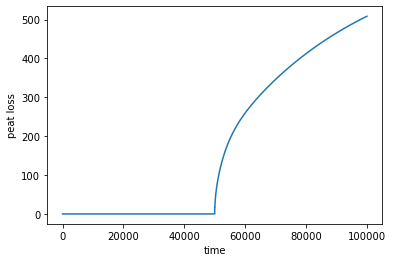

In [10]:
peat_over_time_drained = drained.sum(axis=1)
peat_over_time_undrained = undrained.sum(axis=1)

# Plot peat amount over time
plt.figure()
plt.ylabel('peat amount')
plt.xlabel('time')
plt.plot(peat_over_time_drained, label='drained')
plt.plot(peat_over_time_undrained, label='undrained')
plt.fill_between(x=range(len(peat_over_time_drained)),
                 y1=peat_over_time_drained, y2=peat_over_time_undrained,
                 alpha=0.2)
plt.legend()

# Peat loss over time
peat_lost = peat_over_time_undrained - peat_over_time_drained
plt.figure()
plt.ylabel('peat loss')
plt.xlabel('time')
plt.plot(peat_lost)

# 2D Numerics

In [13]:
# Old, non-working version using Langtangen's book
# Page 175 in Langtangen's book.
# Code from https://github.com/hplgit/fdm-book/blob/master/src/wave/wave2D_u0/wave2D_u0.py
OLD_2D_VERSION = False
if OLD_2D_VERSION:
    def check_stability(dx, dy, dt, c_squared):
        stability_limit = 1/np.sqrt(c_squared*(1/dx**2 + 1/dy**2))
        if dt > stability_limit:
            raise ValueError(f'error: stability limit exceeded. dt = {dt} > {stability_limit}')
        
        return 0

    def advance_vectorized(u, u_n, u_nm1, f_a, Cx2, Cy2, dt2,
                        step1=False):
        if step1:
            dt = sqrt(dt2)  # save
            Cx2 = 0.5*Cx2;  Cy2 = 0.5*Cy2; dt2 = 0.5*dt2  # redefine
            D1 = 1;  D2 = 0
        else:
            D1 = 2;  D2 = 1
        u_xx = u_n[:-2,1:-1] - 2*u_n[1:-1,1:-1] + u_n[2:,1:-1]
        u_yy = u_n[1:-1,:-2] - 2*u_n[1:-1,1:-1] + u_n[1:-1,2:]
        u[1:-1,1:-1] = D1*u_n[1:-1,1:-1] - D2*u_nm1[1:-1,1:-1] + \
                    Cx2*u_xx + Cy2*u_yy + dt2*f_a[1:-1,1:-1]
        if step1:
            u[1:-1,1:-1] += dt*V[1:-1, 1:-1]
        # Boundary condition u=0
        j = 0
        u[:,j] = 0
        j = u.shape[1]-1
        u[:,j] = 0
        i = 0
        u[i,:] = 0
        i = u.shape[0]-1
        u[i,:] = 0
        return u

    def run_all_timesteps_2D(u_new, u, u_old):
        solution = np.zeros(shape=(MAX_NITER, u.shape[0], u.shape[1]))
        solution[0] = u
        for niter in range(1, MAX_NITER):
            
            #solve
            u_new = advance_vectorized(u=u_new, u_n=u, u_nm1=u_old, f_a=f_ext,
                                    Cx2=c_squared*(dx/dt)**2, Cy2=c_squared*(dy/dt)**2,
                                    dt2=dt**2)
            solution[niter] = u_new
            
            u_old = u.copy()
            u = u_new.copy()
            
        return solution  

    # Parameters
    dx = 1. # m
    dy = 1. #m
    dt = 1e-10

    Lx = 10 # m
    Ly = Lx
    MAX_NITER = int(100)
    grid_length_x = int(Lx/dx)
    grid_length_y = int(Ly/dy)
    simulated_time = int(dt*MAX_NITER)

    # 2D Mesh
    x = np.linspace(0, Lx-1, grid_length_x)
    y = np.linspace(0, Ly-1, grid_length_y)
    xv = x.reshape((x.size,1))
    yv = y.reshape((1, y.size))

    b = 0.001 # friction term
    c_squared = 1.0 # coefficient of wave
    f_ext = 0.000001 + 0*xv*yv # external force


    # Initial values
    u_new = 1 * xv*yv # u at time n+1
    u = 1 * xv*yv # u at time n
    u_old = 1 * xv*yv # u at time n-1


    # Check stability
    check_stability(dx, dy, dt, c_squared)


In [125]:
# Opa's wonderful gift code from https://github.com/LukeEcomod/scipy_ode_solver/blob/main/A2_2D_wave_damped_wave_equation_external_force.ipynb
from scipy.integrate import solve_ivp

# Grid resolution and max length
dx = 0.25
dy = 0.25
lx = 10
ly = 10

# Number of gridpoints
Nx = int(lx/dx) + 1
Ny = int(ly/dy) + 1

# grid point vectors
x = np.linspace(0,lx,Nx)
y = np.linspace(0,ly,Ny)

def external_force(x, y, t, B, Nx, Ny):
    f_ext = B
    # if t < 4.0 and t > 1:
    #     ind_x = np.where((x>= 2.5) & (x<=3.5))[0]
    #     ind_y = np.where((y>=1.5) & (y<=4.5))[0]
    #     for ix in ind_x:
    #         for iy in ind_y:
    #             f_ext[ix,iy] = B
    return f_ext

def odefun(u, t, B, a, c, x, y, dx, dy, Nx, Ny, drainage_niter, drainage_position):
    y1 = u[:Nx*Ny].reshape(Nx,Ny)
    y2 = u[Nx*Ny:].reshape(Nx,Ny)
    
    # Set drainage
    if t > drainage_niter:
        y1[0:drainage_position[0], drainage_position[1]] = 0.5
        y2[0:drainage_position[0], drainage_position[1]] = 0.0
    
    dy1dt = y2

    f_ext = external_force(x, y, t, B, Nx, Ny)

    dy2dt = np.zeros((Nx, Ny))

    # First calculate only the c^2(u_xx + u_yy) term for dy2dt
    dy2dt[1:-1, 1:-1] = c**2*((y1[2:, 1:-1] - 2*y1[1:-1, 1:-1] + y1[:-2,1:-1] ) / (dx)**2 + (y1[1:-1, 2:] - 2*y1[1:-1, 1:-1] + y1[1:-1,:-2]) / (dy)**2)
    
    # Then add the other terms to dy2dt
    dy2dt[1:-1, 1:-1] = (dy2dt - a*y2 + f_ext)[1:-1, 1:-1] # the slicing is needed to preserve diriBC in the boundaries
    

    dy1dt = dy1dt.reshape(Nx*Ny,)
    dy2dt = dy2dt.reshape(Nx*Ny,)

    return np.concatenate((dy1dt, dy2dt))

a = 0.1
B = 0.1
c = 0.5

In [126]:
# Run simulations
u_start = np.zeros((2*Nx*Ny,))
NITER = 100
DRAINAGE_NITER = 20
DRAINAGE_POSITION = (int(Nx/4), int(Ny/3))

sol_undrained = solve_ivp(lambda t,u: odefun(u,t,B,a,c,x,y,dx,dy,Nx,Ny, DRAINAGE_NITER, DRAINAGE_POSITION),
                          (0, NITER), u_start, t_eval=np.linspace(0, 100, NITER+1))


[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.0023096  -0.00466264 ... -0.00466264 -0.0023096
   0.        ]
 [ 0.         -0.00466264 -0.00969133 ... -0.00969133 -0.00466264
   0.        ]
 ...
 [ 0.         -0.00466264 -0.00969133 ... -0.00969133 -0.00466264
   0.        ]
 [ 0.         -0.0023096  -0.00466264 ... -0.00466264 -0.0023096
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.00251015 -0.00457141 ... -0.00457141 -0.00251015
   0.        ]
 [ 0.         -0.00457141 -0.01059977 ... -0.01059977 -0.00457141
   0.        ]
 ...
 [ 0.         -0.00457141 -0.01059977 ... -0.01059977 -0.00457141
   0.        ]
 [ 0.         -0.00251015 -0.00457141 ... -0.00457141 -0.00251015
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 0.          0.          0.         ...  0.     

In [127]:
# Reshape outputs
peat_surface = sol.y[:Nx*Ny, :].reshape(Nx, Ny, NITER+1).T # first Nx*Ny entries give p
subsidence = sol.y[Nx*Ny:, :].reshape(Nx, Ny, NITER+1).T # Last Nx*Ny entries give dp/dt

# peat_surface[10] returns (Nx, Ny) array at timestep 10.

In [122]:
# Compute

In [123]:
# Plot with matplotlib SLOW!!
# It is very slow. I tried to use Mayavi, but I couldn't install it in Colab
PLOT_3D_MATPLOTLIB = False

if PLOT_3D_MATPLOTLIB:
    from mpl_toolkits import mplot3d

    fig = plt.figure()
    ax = plt.axes(projection='3d')

    X, Y = np.meshgrid(x,y)

    ax.plot_surface(X=X, Y=Y, Z=solution_2D[50], rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_title('surface')

In [124]:
# plot with mayavi. Not available in google colab
from mayavi import mlab
mlab.close(all=True)
mlab.init_notebook()

# Create a figure with white background and black foreground
mlab.figure(1, fgcolor=(.0, .0, .0), bgcolor=(1.0, 1.0, 1.0))

# ’representation’ sets type of plot: "wireframe", "surface", etc.
x = np.linspace(0, lx, Nx)
y = np.linspace(0, ly, Ny)
xv = x.reshape((x.size,1))
yv = y.reshape((1, y.size))
mlab.surf(xv, yv, peat_surface[3], extent=(0,1,0,1,0,1), representation="surface")
# Decorate axes (nb_labels is the number of labels used
# in each direction)
mlab.axes(xlabel="x", ylabel="y", zlabel="peat", nb_labels=5, color=(0., 0., 0.))
# Decorate the plot with a title
mlab.title("peat height", size=0.4)


Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…